<a href="https://colab.research.google.com/github/Kaia-nyoung/2025-ML-class/blob/main/9%EC%A3%BC%EC%B0%A8/UCI_HAR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
import numpy as np
import pandas as pd
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns

In [26]:
# 1) 기본 파일 로더
def load_file(filepath):
    # txt 파일을 numpy로 읽어옴
    data = np.loadtxt(filepath)
    return data

In [27]:
# 2) 여러 센서 축 파일을 한 덩어리로 읽어 3차원으로 쌓는 함수
def load_group(filenames, prefix=''):
    loaded = []
    for name in filenames:
        # prefix + 파일이름 으로 경로 완성
        data = load_file(prefix + name)
        loaded.append(data)
    # (samples, timesteps, features) 형태로 만들기 위해 세 번째 축으로 쌓기
    loaded = np.dstack(loaded)
    return loaded

In [28]:
# 3) train / test 각각을 읽는 함수
def load_dataset_group(group, prefix=''):
    # 예: 'UCI HAR Dataset/train/Inertial Signals/'
    filepath = prefix + group + '/Inertial Signals/'
    # UCI HAR Dataset에서 쓰는 9개 시그널 파일들
    filenames = [
        'body_acc_x_'  + group + '.txt',
        'body_acc_y_'  + group + '.txt',
        'body_acc_z_'  + group + '.txt',
        'body_gyro_x_' + group + '.txt',
        'body_gyro_y_' + group + '.txt',
        'body_gyro_z_' + group + '.txt',
        'total_acc_x_' + group + '.txt',
        'total_acc_y_' + group + '.txt',
        'total_acc_z_' + group + '.txt'
    ]
    # X: (샘플수, 타임스텝, 9개 feature)
    X = load_group(filenames, filepath)
    # y: 라벨 (1~6)
    y = load_file(prefix + group + '/y_' + group + '.txt')
    return X, y

In [29]:

# 4) 전체 dataset 불러오기
def load_dataset(dataset_root='/content/drive/MyDrive/ML-MK/UCI_HAR/'):
    # train 세트
    trainX, trainy = load_dataset_group('train', dataset_root)
    # test 세트
    testX, testy   = load_dataset_group('test', dataset_root)

    # 원래 라벨이 1~6이라서 one-hot 할 때는 0~5로 바꿔줌
    trainy_one_hot = to_categorical(trainy - 1)
    testy_one_hot  = to_categorical(testy - 1)

    return trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot



In [30]:
trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot = load_dataset()

from sklearn.model_selection import train_test_split

X_train,X_val,y_train_one_hot,y_val_one_hot,y_train,y_val=train_test_split(trainX, trainy_one_hot, trainy,test_size=0.2,random_state=100)

X_train.shape,X_val.shape,y_train_one_hot.shape,y_val_one_hot.shape,y_train.shape,y_val.shape

((5881, 128, 9), (1471, 128, 9), (5881, 6), (1471, 6), (5881,), (1471,))

In [31]:
n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train_one_hot.shape[1]

In [32]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import (
    Input, Dense, Flatten, Dropout,
    Conv1D, MaxPooling1D, LSTM, concatenate
)
from tensorflow.keras.utils import to_categorical

##Level_1
# layer 1
inputs1_1= Input(shape=(n_timesteps,n_features))##128,9
conv1_1 = Conv1D(filters=128, kernel_size=3, activation='relu')(inputs1_1) ##none,126,128
# layer 2
inputs1_2= Input(shape=(n_timesteps,n_features))
conv1_2 = Conv1D(filters=128, kernel_size=5, activation='relu')(inputs1_2)##124,128
# layer 3
inputs1_3= Input(shape=(n_timesteps,n_features))
conv1_3 = Conv1D(filters=128, kernel_size=7, activation='relu')(inputs1_3)##122,128
# layer 4
inputs1_4= Input(shape=(n_timesteps,n_features))
conv1_4 = Conv1D(filters=128, kernel_size=9, activation='relu')(inputs1_4)##120,128

# merge1
merged_1 = concatenate([conv1_1,conv1_2,conv1_3,conv1_4],axis=1)

#maxpool1
pool_1=MaxPooling1D(pool_size=5)(merged_1)

##Level_2
# layer 1
conv2_1 = Conv1D(filters=64, kernel_size=3, activation='relu')(pool_1)
# layer 2
conv2_2 = Conv1D(filters=64, kernel_size=5, activation='relu')(pool_1)
# layer 3
conv2_3 = Conv1D(filters=64, kernel_size=7, activation='relu')(pool_1)
# layer 4

conv2_4 = Conv1D(filters=64, kernel_size=9, activation='relu')(pool_1)
# merge2
merged_2 = concatenate([conv2_1,conv2_2,conv2_3,conv2_4],axis=1)

#maxpool2
pool_2=MaxPooling1D(pool_size=5)(merged_2)


##Level_3
# layer 1
conv3_1 = Conv1D(filters=32, kernel_size=3, activation='relu')(pool_2)
# layer 2
conv3_2 = Conv1D(filters=32, kernel_size=5, activation='relu')(pool_2)
# layer 3
conv3_3 = Conv1D(filters=32, kernel_size=7, activation='relu')(pool_2)
# layer 4

conv3_4 = Conv1D(filters=32, kernel_size=9, activation='relu')(pool_2)
# merge2
merged_3 = concatenate([conv3_1,conv3_2,conv3_3,conv3_4],axis=1)

#maxpool2
pool_3=MaxPooling1D(pool_size=5)(merged_3)


#flatten
flat_cnn=Flatten()(pool_3)

##dense layer
dense = Dense(512, activation='relu')(flat_cnn)
outputs = Dense(n_outputs, activation='softmax')(dense)

##MODEL
cnn3_model = Model([inputs1_1, inputs1_2, inputs1_3,inputs1_4], outputs)

cnn3_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
cnn3_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 9)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 128, 9)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_2       │ (None, 128, 9)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_3       │ (None, 128, 9)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 126, 128)  │      3,584 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 124, 128)  │      5,888 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 122, 128)  │      8,192 │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 120, 128)  │     10,496 │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 492, 128)  │          0 │ conv1d[0][0],     │
│ (Concatenate)       │                   │            │ conv1d_1[0][0],   │
│                     │                   │            │ conv1d_2[0][0],   │
│                     │                   │            │ conv1d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 98, 128)   │          0 │ concatenate[0][0] │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 96, 64)    │     24,640 │ max_pooling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_5 (Conv1D)   │ (None, 94, 64)    │     41,024 │ max_pooling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_6 (Conv1D)   │ (None, 92, 64)    │     57,408 │ max_pooling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_7 (Conv1D)   │ (None, 90, 64)    │     73,792 │ max_pooling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 372, 64)   │          0 │ conv1d_4[0][0],   │
│ (Concatenate)       │                   │            │ conv1d_5[0][0],   │
│                     │                   │            │ conv1d_6[0][0],   │
│                     │                   │            │ conv1d_7[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_1     │ (None, 74, 64)    │          0 │ concatenate_1[0]… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_8 (Conv1D)   │ (None, 72, 32)    │      6,176 │ max_pooling1d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_9 (Conv1D)   │ (None, 70, 32)    │     10,272 │ max_pooling1d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_10 (Conv1D)  │ (None, 68, 32)    │     14,368 │ max_pooling1d_1[

 Total params: 1,179,014 (4.50 MB)

 Trainable params: 1,179,014 (4.50 MB)

 Non-trainable params: 0 (0.00 B)

In [33]:
model_history=cnn3_model.fit(x=[X_train,X_train,X_train,X_train], y=y_train_one_hot, epochs=30, batch_size=32,validation_split=0.1)


Epoch 1/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 20s 64ms/step - accuracy: 0.7531 - loss: 0.6090 - val_accuracy: 0.9406 - val_loss: 0.1441
Epoch 2/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9491 - loss: 0.1203 - val_accuracy: 0.9542 - val_loss: 0.1010
Epoch 3/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9492 - loss: 0.1152 - val_accuracy: 0.9542 - val_loss: 0.1007
Epoch 4/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9531 - loss: 0.1085 - val_accuracy: 0.9525 - val_loss: 0.1046
Epoch 5/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9577 - loss: 0.0979 - val_accuracy: 0.9525 - val_loss: 0.1031
Epoch 6/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9564 - loss: 0.0982 - val_accuracy: 0.9559 - val_loss: 0.0878
Epoch 7/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9624 - loss: 0.0886 - val_accuracy: 0.9440 - val_loss: 0.1371
Epoch 8/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9585 - loss: 0.1105 - val_accuracy: 

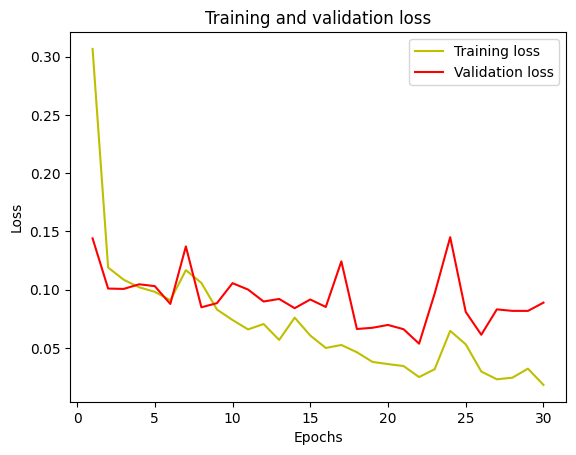

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

loss =model_history.history['loss']
val_loss =model_history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

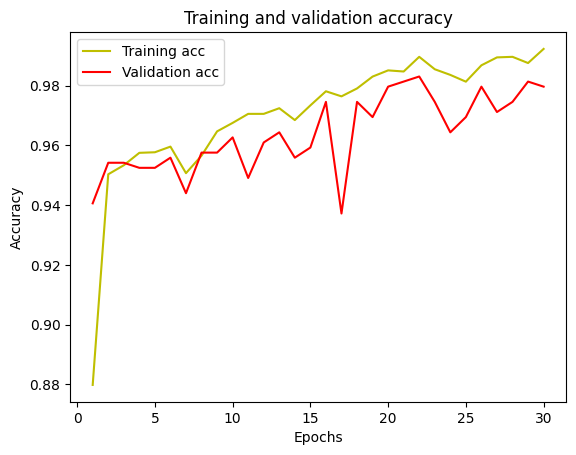

In [35]:
acc =model_history.history['accuracy']
val_acc =model_history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step
[[  0   0   0   0   0   0   0]
 [466   5  25   0   0   0   0]
 [  1 452  18   0   0   0   0]
 [  0   3 416   1   0   0   0]
 [  0   2   0 421  68   0   0]
 [  0   0   0  56 476   0   0]
 [  0   0   0   0  27 510   0]]
0.031218187987784186
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       0.01      0.01      0.01       496
         2.0       0.04      0.04      0.04       471
         3.0       0.00      0.00      0.00       420
         4.0       0.12      0.14      0.13       491
         5.0       0.00      0.00      0.00       532
         6.0       0.00      0.00      0.00       537

    accuracy                           0.03      2947
   macro avg       0.02      0.03      0.03      2947
weighted avg       0.03      0.03      0.03      2947



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_

<Axes: >

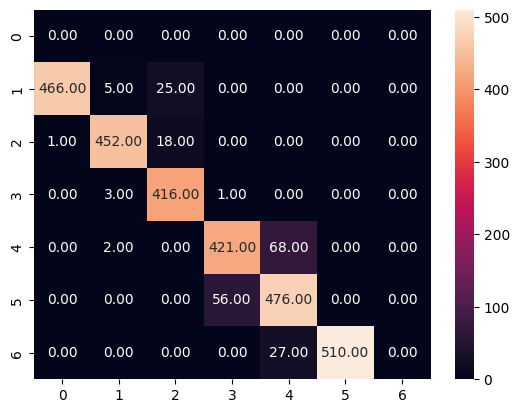

In [36]:

from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
pred=cnn3_model.predict([testX,testX,testX,testX])
pred=np.argmax(pred, axis=-1)
cm=confusion_matrix(testy,pred)
print(cm)
print(accuracy_score(testy,pred))
print(classification_report(testy,pred))
sns.heatmap(cm, annot=True, fmt = '.2f')